In [1]:
from IPython.display import clear_output

Hello


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

/cis/home/rmuthuk1/anaconda3/envs/advrob/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [ ]:
assert torch.cuda.is_available()
cuda = torch.device('cuda')

In [6]:
# Handcrafted data domain specified by corners
x_start = 1.0
x_end = 5.5
y_start = -1.5
y_end = 1.5
corners = [x_start, x_end, y_start, y_end]

# Handcrafted reference points
x0 = [3.8, 0.9]
x1 = [2.7, 0.361]
x2 = [4.94, 0.452]
xtil = [1.4, -0.276]
reference_points = [x0, x1, x2, xtil]

# stale line from x0 to xtil
#x7 = np.linspace(1.4,3.8,10)
#y7 = 0.49*x7 - 0.962

In [7]:
# Handcrafter classifiers 
def h_star_bnd(t : torch.Tensor):
    return torch.sin(t+0.5)

def h_star(t: torch.Tensor):
    assert len(t.shape) == 2 # shape is batch x inp_dimensions 
    assert t.shape[1] == 2
    out = torch.zeros_like(t)
    
    for index in range(t.shape[0]):
        out[index][0] = h_star_bnd(t[index][0])
        out[index][1] = t[index][1] 

    return out 

def h_1_bnd(t: torch.Tensor):
    return torch.sin(t+0.5)  - 0.75*torch.cos(t+0.5) - 0.2*torch.sin(3*(t+0.5)) - 0.1 

def h_1(t: torch.Tensor):
    assert len(t.shape) == 2 # shape is batch x inp_dimensions 
    assert t.shape[1] == 2
    out = torch.zeros_like(t)
    
    for index in range(t.shape[0]):
        out[index][0] = h_1_bnd(t[index][0])
        out[index][1] = t[index][1] 

    return out 


def h_2_bnd(t: torch.Tensor):
    return torch.sin(t+0.5) + 0.07*torch.sin(5*(t+0.5)) + 0.15*((t+0.5)**2) - 0.49*(t+0.5) + 0.2 - 1*(F.relu(t-4.3))**2

def h_2(t: torch.Tensor):
    assert len(t.shape) == 2 # shape is batch x inp_dimensions 
    assert t.shape[1] == 2
    out = torch.zeros_like(t)
    
    for index in range(t.shape[0]):
        out[index][0] = h_2_bnd(t[index][0])
        out[index][1] = t[index][1] 

    return out   

def predict_label(classifier, input):
    dim_flag = False 
    if input.dim() == 1:
        input = input.unsqueeze(0)
        dim_flag = True 
    out = classifier(input)
    labels = torch.argmax(out, dim=1)
    if dim_flag:
        return labels[0].item()
    else: 
        return labels 

In [8]:
# only needed for plotting so returning numpy arrays
def generate_decision_boundary(corners):
    x_start, x_end = corners[0], corners[1]
    x = torch.linspace(x_start,x_end,100)
    y_star = h_star_bnd(x).detach().cpu()
    y_1 = h_1_bnd(x).detach().cpu()
    y_2 = h_2_bnd(x).detach().cpu()
    return x.numpy(), y_star.numpy(), y_1.numpy(), y_2.numpy()


def generate_data_domain(corners):
    x_start, x_end, y_start, y_end = corners[0], corners[1], corners[2], corners[3]
    x_left = np.ones(1000)*x_start
    y_left = np.linspace(y_start,y_end,1000)

    x_right = torch.ones(1000)*x_end
    y_right = np.linspace(y_start,y_end,1000)

    x_down = np.linspace(x_start,x_end,100)
    y_down = np.ones(100)*y_start

    x_up = np.linspace(x_start,x_end,100)
    y_up = np.ones(100)*y_end

    return x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up

In [169]:
def plot_synthetic(corners, reference_points, show_h1=False, show_h2=False):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)

    # plot the data domain
    plt.plot(x_left, y_left, color="black", linewidth=3)
    plt.plot(x_right, y_right, color="black", linewidth=3)
    plt.plot(x_down, y_down, color="black", linewidth=3)
    plt.plot(x_up, y_up, color="black", linewidth=3)
    
    # plot true labeling decision boundary 
    plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    plt.fill_between(x, y1=y_star, y2=y_down, color="red", alpha=0.05)
    plt.fill_between(x, y1=y_star, y2=y_up, color="green", alpha=0.05)

    if show_h1:
        plt.plot(x, y_1, color='magenta', label="h1", linestyle="dashed")
        plt.fill_between(x, y1=y_1, y2=y_star, color= "magenta", alpha= 0.05, hatch='///')
    
    if show_h2:
        plt.plot(x, y_2, color='purple', label="h2", linestyle="dashed")
        plt.fill_between(x, y1=y_2, y2=y_star, color= "purple", alpha= 0.05, hatch='///')
    
    # plot reference points
    plt.plot(x0[0], x0[1], color="red", marker=r"$x$", markersize=9)
    plt.plot(x1[0], x1[1], color="red", marker=r"$x_1$", markersize=12)
    plt.plot(x2[0], x2[1], color="red", marker=r"$x_2$", markersize=12)
    plt.plot(xtil[0], xtil[1], color='red', marker=r'$\tilde{x}$', markersize=12)
    # plt.plot([4.7],[0.1], color='red', marker=r'$\tilde{x}$', markersize=11)
    if show_h1 or show_h2:
        plt.legend(bbox_to_anchor=(0.32, -0.005), loc="upper left", ncol=2)
    else:
        plt.legend(bbox_to_anchor=(0.4, -0.005), loc="upper left", ncol=1)
    plt.axis("off")
    
    loc_str = "./synthetic_data"
    if show_h1:
        loc_str += "_h1.pdf"
    elif show_h2:
        loc_str += "_h2.pdf"
    else:
        loc_str += "_hstar.pdf"
        
    plt.savefig(loc_str, bbox_inches='tight')

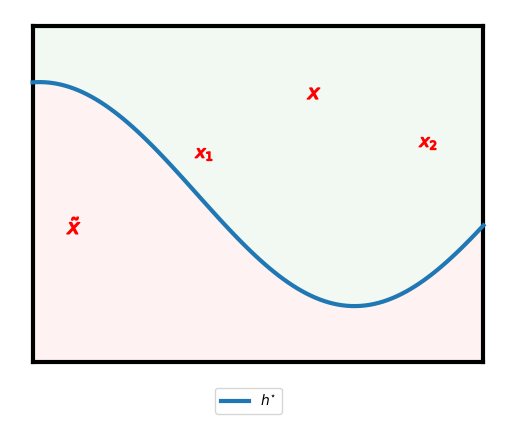

In [170]:
plot_synthetic(corners, reference_points)

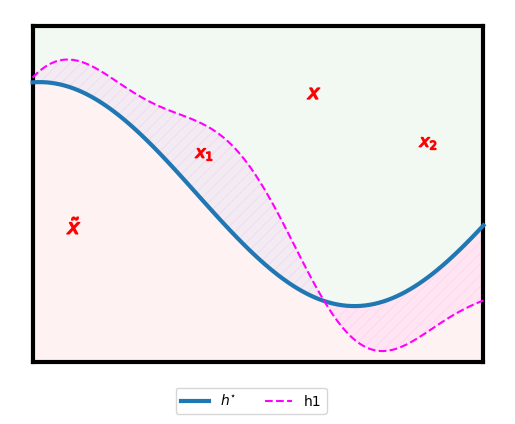

In [171]:
plot_synthetic(corners, reference_points, show_h1=True)

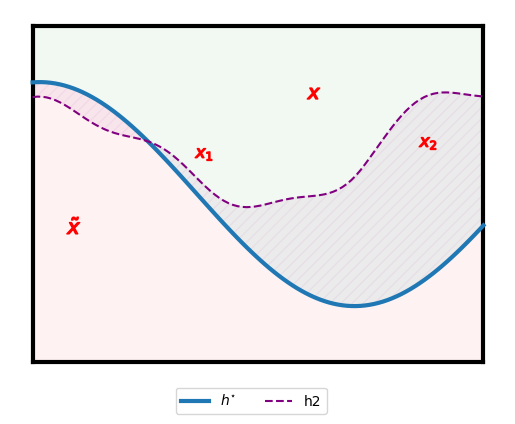

In [172]:
plot_synthetic(corners, reference_points, show_h2=True)

In [14]:
reference_domain = torch.zeros(4,2, device=cuda)
reference_labels = torch.ones(4, device=cuda)

for (index, p) in enumerate(reference_points):
    reference_domain[index] = torch.tensor([reference_points[index][0], reference_points[index][1]])
    
reference_labels = predict_label(h_star, reference_domain)

print(reference_domain)
print(reference_labels)

tensor([[ 3.8000,  0.9000],
        [ 2.7000,  0.3610],
        [ 4.9400,  0.4520],
        [ 1.4000, -0.2760]], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')


In [16]:
num_points = 200
x_val = torch.linspace(x_start, x_end, num_points, device=cuda)
y_val = torch.linspace(y_start, y_end, num_points, device=cuda)

domain = torch.zeros(num_points**2, 2, device=cuda)

for index in range(num_points**2):
    domain[index] = torch.tensor([x_val[index//num_points], y_val[index%num_points]])

true_labels = predict_label(h_star, domain)   

In [148]:
def compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier = None, beta=0.7):
    assert len(selected_domain) == len(selected_labels)
    
    unsafe_dirs = torch.zeros_like(selected_domain)
    unsafe_normalization = torch.ones(len(selected_domain), device=cuda)*float('inf')
    
    for (index, input) in enumerate(selected_domain):
        norm_diff = torch.linalg.norm(input - reference_input, ord=2)
        unsafe_dirs[index] = (input-reference_input)/norm_diff
            
        if selected_labels[index] != reference_label:
            if classifier is not None: 
                # binary search to compute normalization when the true labeling function is given
                low = 0
                high = 1
                while high - low > 1e-5:
                    alpha = (high + low)/2
                    input_alpha = reference_input + alpha*(input-reference_input)
                    label_alpha = predict_label(classifier, input_alpha)
                    if label_alpha == reference_label:
                        low = alpha
                    else:
                        high = alpha
                alpha = low
                input_alpha = reference_input + alpha*(input-reference_input)
                unsafe_normalization[index] = torch.linalg.norm(input_alpha-reference_input, ord=2)
            else:
                unsafe_normalization[index] = norm_diff*beta 
    
    return unsafe_dirs, unsafe_normalization

In [142]:
def non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type='PL'):
    if dist_type not in ['PL', 'PD', 'WD']:
        raise ValueError('Non-isotropic distance type should be one of PL, PD, WD')
    
    element_wise_mul = torch.mul(unsafe_dir, perturbation)
    
    
    if dist_type == 'PL' or dist_type == 'PD':
        scaled_projections = torch.div(torch.sum(element_wise_mul, dim=1), unsafe_normalization)
        if dist_type == 'PL':
            return torch.max(scaled_projections).detach().cpu().numpy()
        elif dist_type == 'PD':
            return torch.max(torch.abs(scaled_projections)).detach().cpu().numpy()
    
    
    if dist_type == 'WD':
        unsafe_4_norm = torch.linalg.norm(unsafe_dir, dim=1, ord=4)**2 # 4-norm
        modified_normalization = torch.mul(unsafe_normalization, unsafe_4_norm)
        scaled_distances = torch.div(torch.linalg.norm(element_wise_mul, dim=1, ord=2), modified_normalization)
        return torch.max(scaled_distances).detach().cpu().numpy()


In [41]:
distance_types = ['l2', 'l1', 'linf', 'PL', 'PD', 'WD']

In [208]:
def latexify_dist(dist_type: str):
    if dist_type == 'l2': return r'$\ell_2$'
    elif dist_type == 'linf': return r'$\ell_{\infty}$'
    elif dist_type == 'l1': return r'$\ell_1$'
    else: return dist_type

def latexify_inp(index: int):
    if index == 0: return r'$x$'
    elif index == 1: return r'$x_1$'
    elif index == 2: return r'$x_2$'
    elif index == 3: return r'$\tilde{x}$'
    
def latexify_h(index):
    if index is None: return r'$h^{\star}$'
    elif index == 1: return r'$h_1$'
    elif index == 2: return r'$h_2$'

In [77]:
def get_distances(reference_input, reference_label, selected_domain, selected_labels, classifier = None, dist_type='l2'):
    print("Computing " + dist_type + " distances")
    if dist_type not in distance_types:
        raise ValueError('Distance type should be one of l2, l1, linf, PL, PD, WD')
    unsafe_dir, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier=classifier)
                    
    distances = []
    for (index, input) in enumerate(selected_domain):
        if index % 100 == 0:
            clear_output(wait=True)
            print("Computing distances at index: " + str(index) +  ", out of " + str(len(selected_domain) - 1) + " points.")
        perturbation = input - reference_input
        if dist_type == 'l2':
            distance = torch.linalg.norm(perturbation, ord=2).detach().cpu().numpy()
        elif dist_type == 'l1':
            distance = torch.linalg.norm(perturbation, ord=1).detach().cpu().numpy()
        elif dist_type == 'linf':
            distance = torch.linalg.norm(perturbation, ord=float('inf')).detach().cpu().numpy()
        elif dist_type in ['PL', 'PD', 'WD']:
            distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type)
        distances.append(distance)
    return distances

def sublevel_set(selected_domain, distances, threshold):
    sublevel = []
    for input, distance in zip(selected_domain, distances):
        if distance <= threshold:
            sublevel.append(input.detach().cpu().numpy())
    return sublevel

In [180]:
def generate_distances(reference_domain, reference_labels, domain, true_labels, classifier=h_star, distance_types=distance_types):
    distances = dict()
    for dist_type in distance_types:
        for index in range(len(reference_domain)):
            key = "x" + str(index) + "_" + dist_type
            distances[key] = get_distances(reference_domain[index], reference_labels[index], domain, true_labels, classifier=classifier, dist_type=dist_type)
            
    return distances

In [181]:
distances = generate_distances(reference_domain, reference_labels, domain, true_labels)

Computing distances at index: 39900, out of 39999 points.


In [182]:
distances.keys()

dict_keys(['x0_l2', 'x1_l2', 'x2_l2', 'x3_l2', 'x0_l1', 'x1_l1', 'x2_l1', 'x3_l1', 'x0_linf', 'x1_linf', 'x2_linf', 'x3_linf', 'x0_PL', 'x1_PL', 'x2_PL', 'x3_PL', 'x0_PD', 'x1_PD', 'x2_PD', 'x3_PD', 'x0_WD', 'x1_WD', 'x2_WD', 'x3_WD'])

In [195]:
def plot_distance_intensity(corners, reference_points, distances, domain, distance_types=distance_types):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)
    
    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]
    
    for dist_type in distance_types:
        for index in range(len(reference_points)):
            key = "x" + str(index) + "_" + dist_type
            distance_domain = distances[key]
            plt.figure()
            title_str = latexify_dist(dist_type) + " threat "
            title_str += " from reference point " + latexify_inp(index)
            plt.title(title_str)
            
            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)
    
            # plot true labeling decision boundary 
            plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
        
            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=latexify_inp(0), markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=latexify_inp(1), markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=latexify_inp(2), markersize=12)
            plt.plot(xtil[0], xtil[1], color='black', marker=latexify_inp(3), markersize=12)
            
            # Plot the distance intensity map
            plt.scatter(domain_x, domain_y, c=distance_domain, s=2, cmap="plasma")
            plt.colorbar(orientation='horizontal')
            
            plt.axis('off')
            plt.savefig("./distance_intensity_" + key + ".pdf", bbox_inches='tight')

In [ ]:
plot_distance_intensity(corners, reference_points, distances, domain)   

In [197]:
# Compute certified threshold for a given point based on its distances matrix and the collection of all points. 
def compute_certified_threshold(reference_domain, reference_labels, domain, true_labels, distances):
    certified_thresholds = dict()
    for dist_type in distance_types:
        for r_index in range(len(reference_domain)):
            key = "x" + str(r_index) + "_" + dist_type
            reference_label = reference_labels[r_index]
            threshold = float('inf')
            for index in range(len(domain)):
                if true_labels[index] != reference_label and threshold > distances[key][index]:
                    threshold = distances[key][index]
            certified_thresholds[key] = threshold
    return certified_thresholds

In [198]:
reference_labels_h1 = predict_label(h_1, reference_domain)
reference_labels_h2 = predict_label(h_2, reference_domain)

domain_labels_h1 = predict_label(h_1, domain)
domain_labels_h2 = predict_label(h_2, domain)

certified_thresholds_hstar = compute_certified_threshold(reference_domain, reference_labels, domain, true_labels, distances)
certified_thresholds_h1 = compute_certified_threshold(reference_domain, reference_labels_h1, domain, domain_labels_h1, distances)
certified_thresholds_h2 = compute_certified_threshold(reference_domain, reference_labels_h2, domain, domain_labels_h2, distances)

In [210]:
str(certified_thresholds_hstar['x0_PL'])

'1.0008105'

In [212]:
latexify_h(None)

'$h^{\\star}$'

In [213]:
latexify_dist('l2')

'$\\ell_2$'

In [217]:
latexify_inp(0)

'$x$'

In [223]:
def plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds, distance_types=distance_types, h_index=None):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)
    h_str = "h" + str(h_index) if h_index is not None else "hstar"
            
    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]
    
    for dist_type in distance_types:
        for index in range(len(reference_points)):
            key = "x" + str(index) + "_" + dist_type
            distance_domain = distances[key]
            certified_threshold = certified_thresholds[key]
            cert_str = "%.2f" % certified_threshold 
            title_str = latexify_dist(dist_type) + " certified threshold for " + latexify_h(h_index) + " at " + latexify_inp(index) + " is " + cert_str
            plt.figure()
            plt.title(title_str)
            
            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)
    
            # plot true labeling decision boundary 
            plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
            
            if h_index == 1:
                plt.plot(x, y_1, color='magenta', label=latexify(h_index), linestyle="dashed")
                plt.fill_between(x, y1=y_1, y2=y_star, color= "magenta", alpha= 0.05, hatch='///')
            elif h_index == 2:
                plt.plot(x, y_2, color='purple', label=latexify(h_index), linestyle="dashed")
                plt.fill_between(x, y1=y_2, y2=y_star, color= "purple", alpha= 0.05, hatch='///')
    
            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
            plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)
            
            # Plot the sublevel sets upto certified threshold
            epsilons = np.linspace(0, certified_threshold, 5)
            for eps in epsilons: 
                sublevel = sublevel_set(domain, distance_domain, eps)
                sublevel_x = [d[0] for d in sublevel]
                sublevel_y = [d[1] for d in sublevel]
                plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

            plt.axis('off')
            plt.savefig("./certified threshold_" + h_str + key + ".pdf", bbox_inches='tight')



/tmp/ipykernel_2287575/3118818498.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


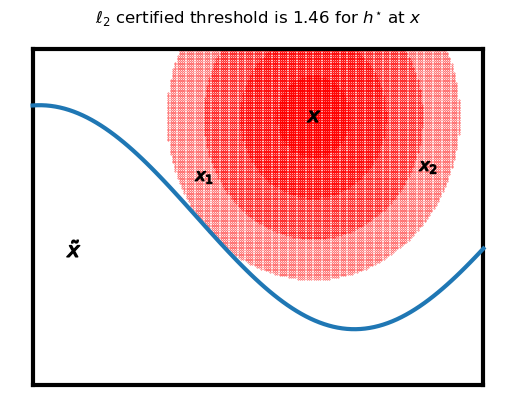

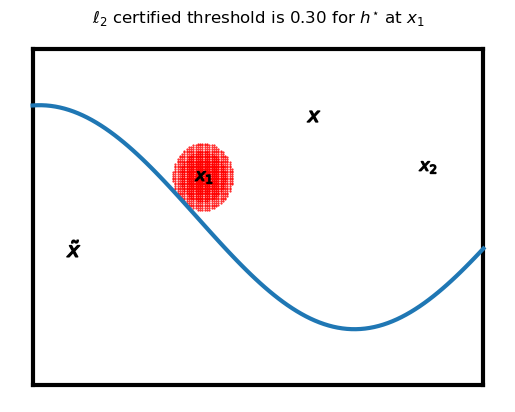

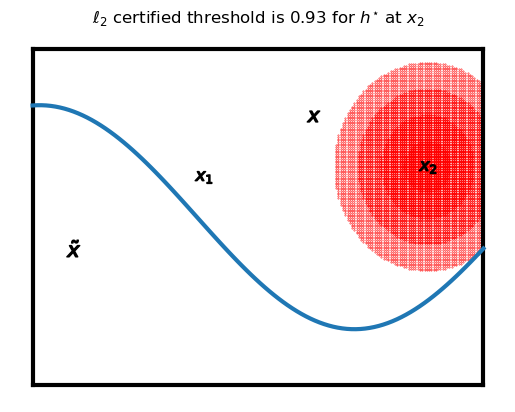

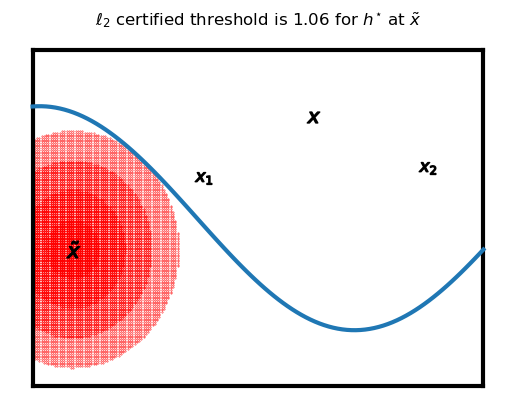

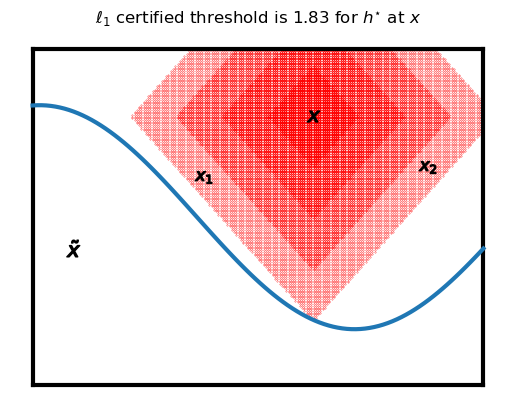

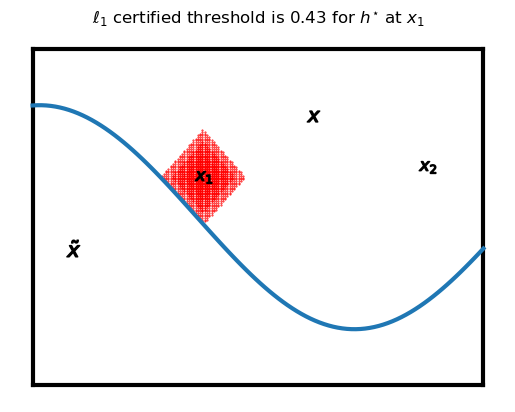

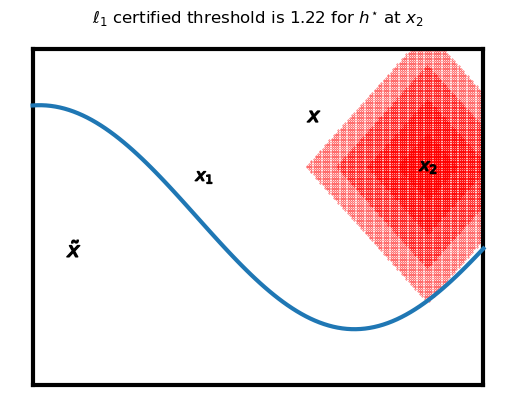

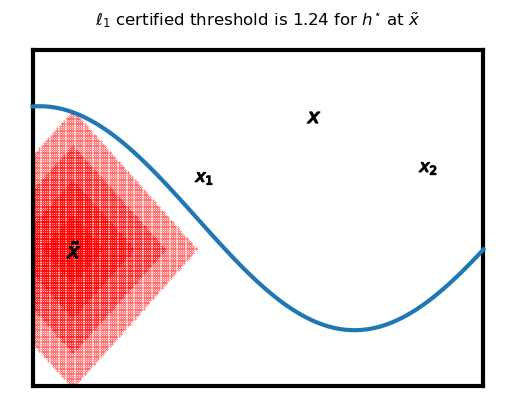

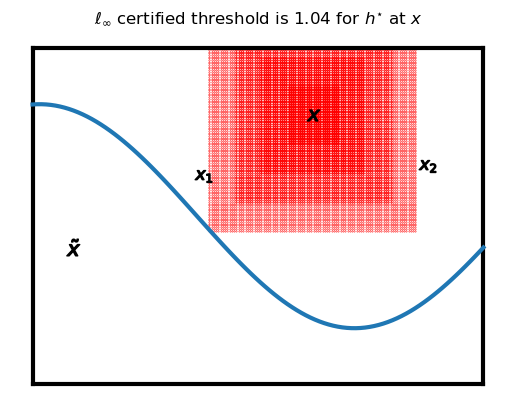

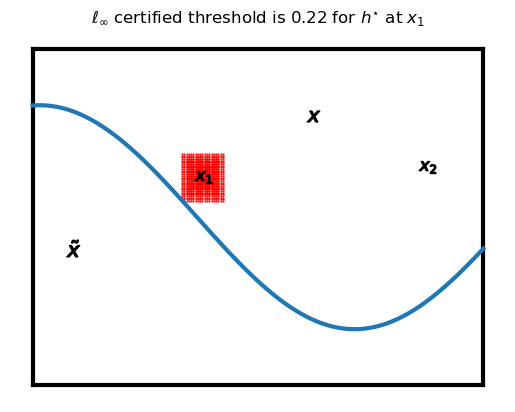

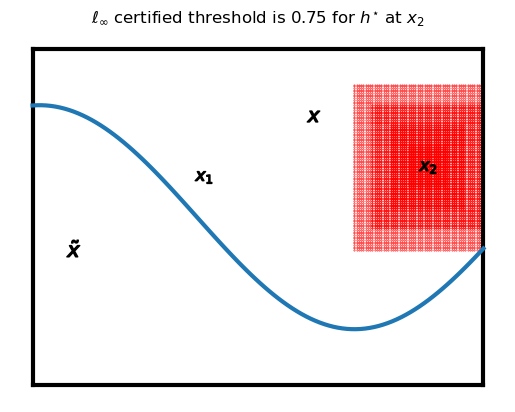

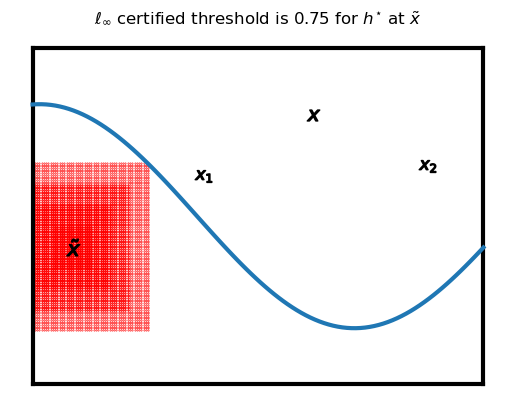

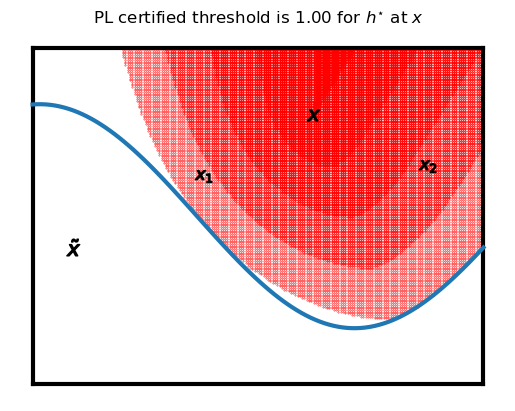

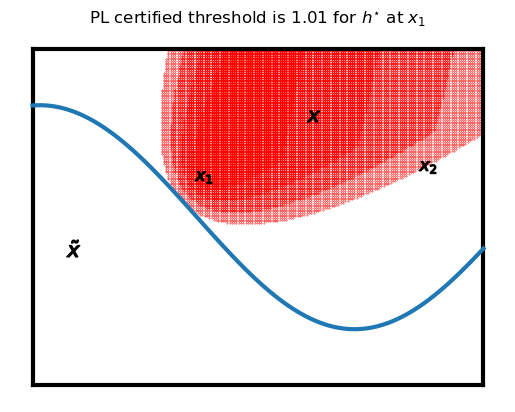

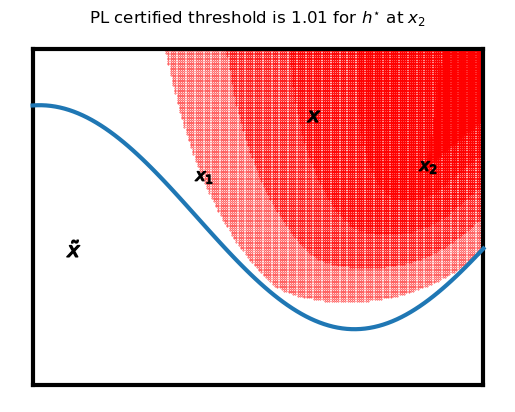

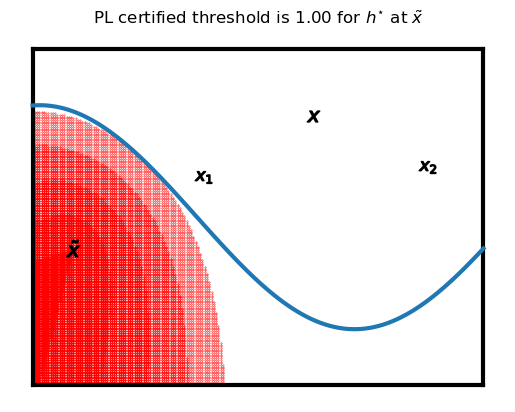

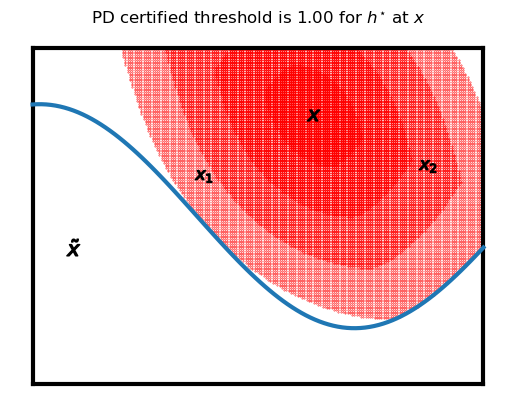

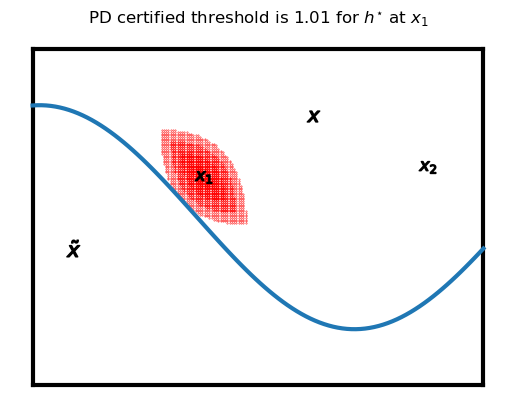

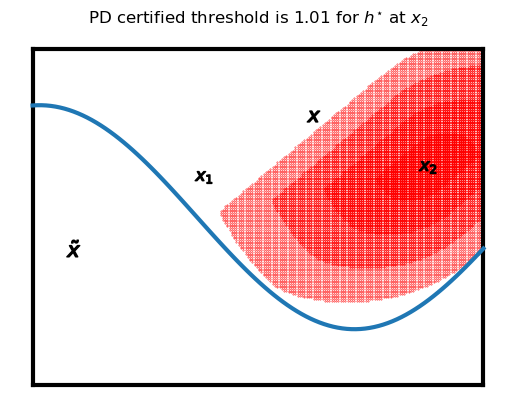

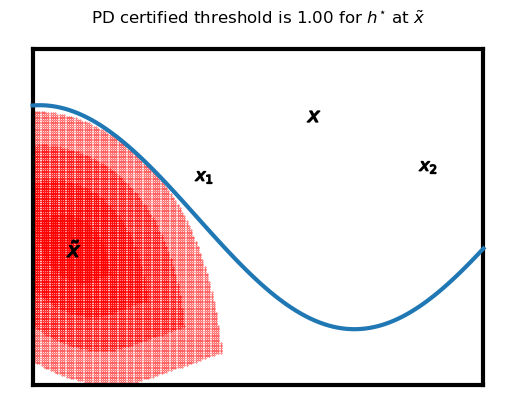

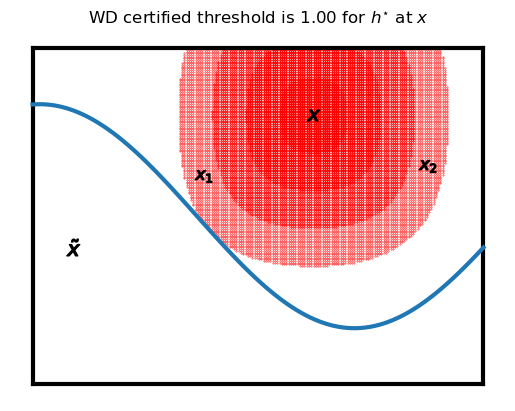

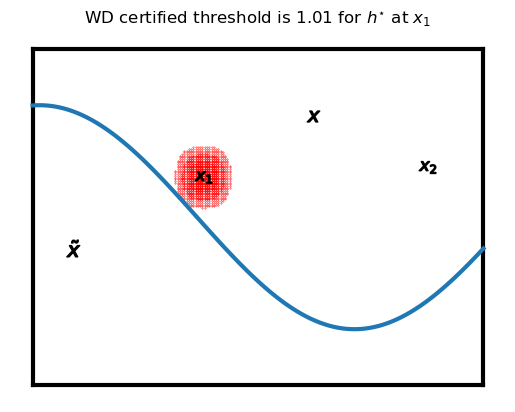

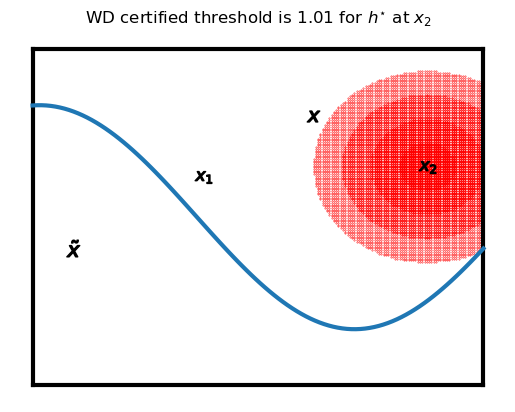

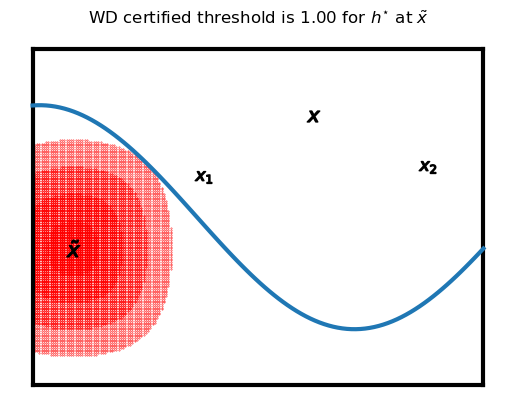

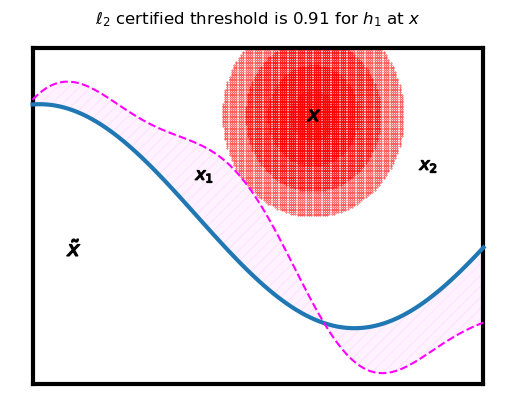

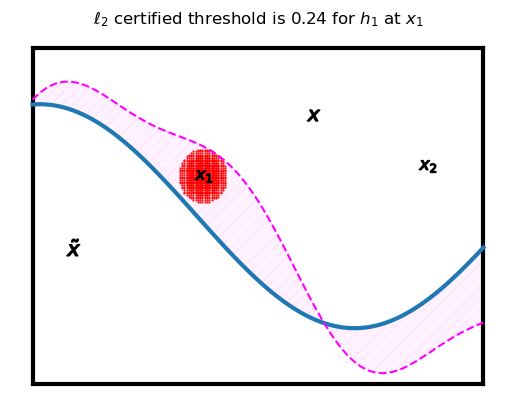

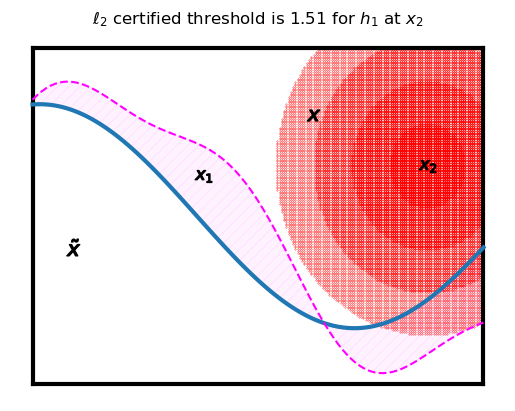

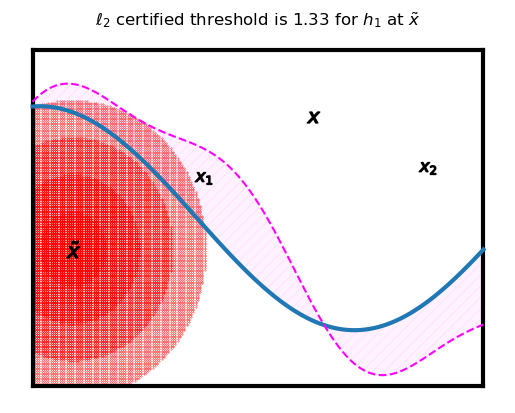

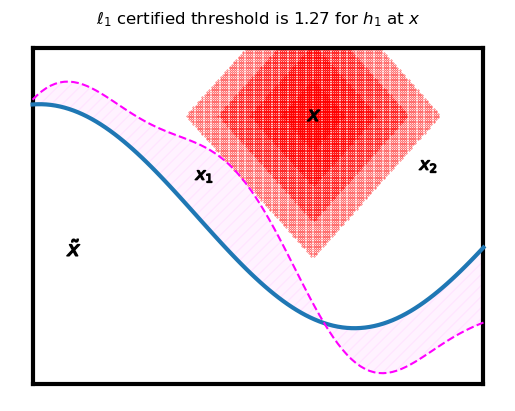

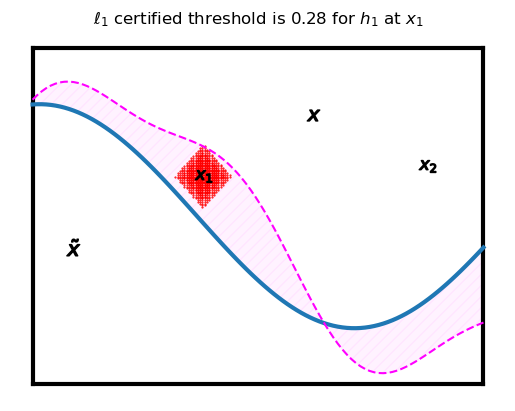

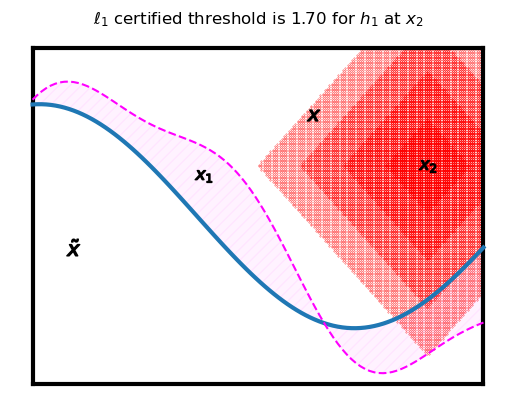

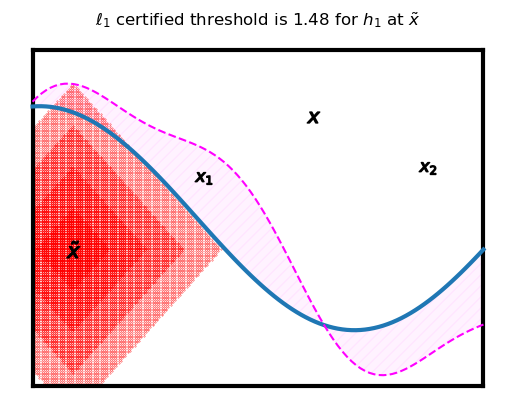

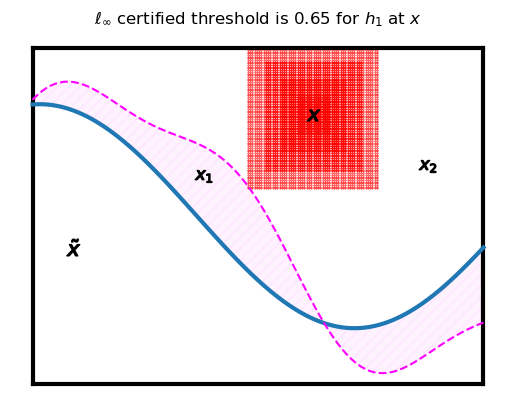

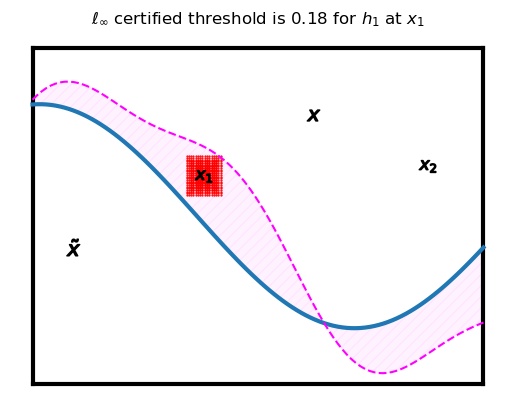

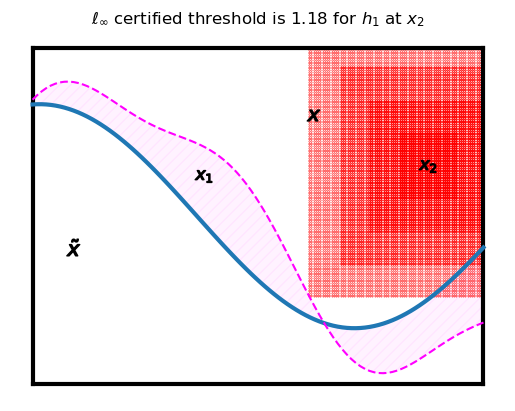

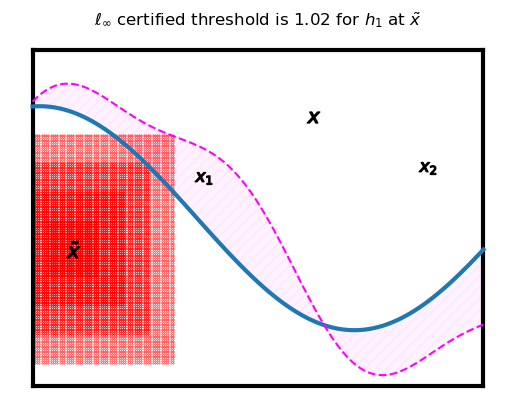

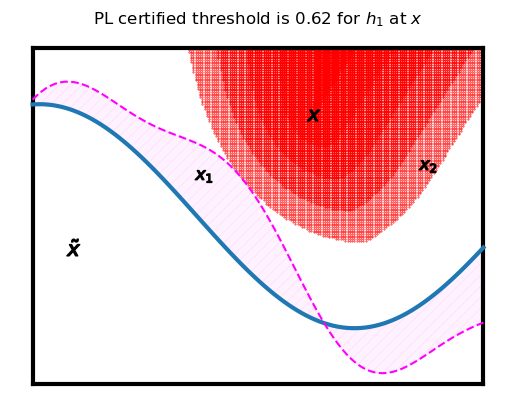

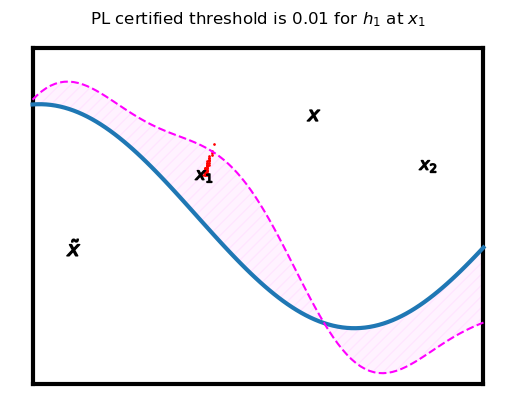

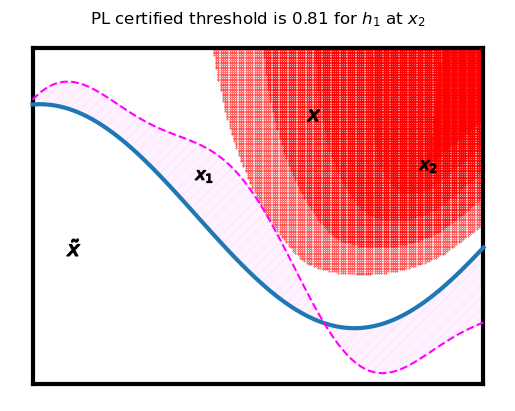

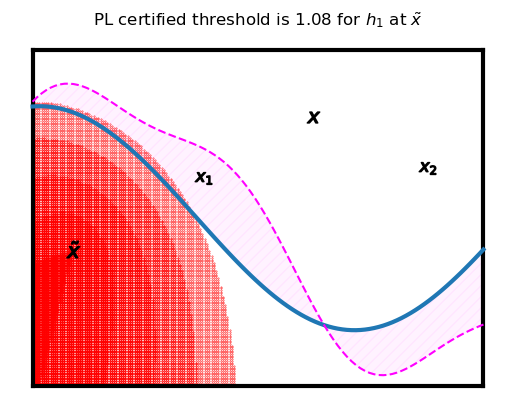

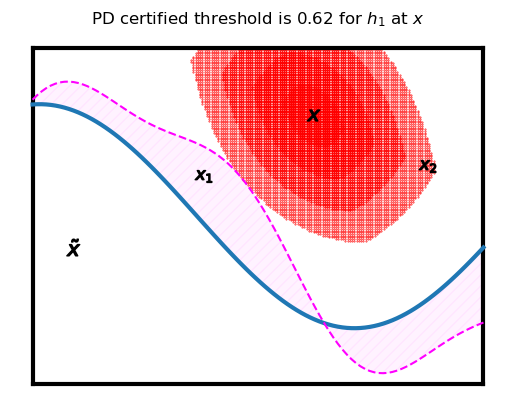

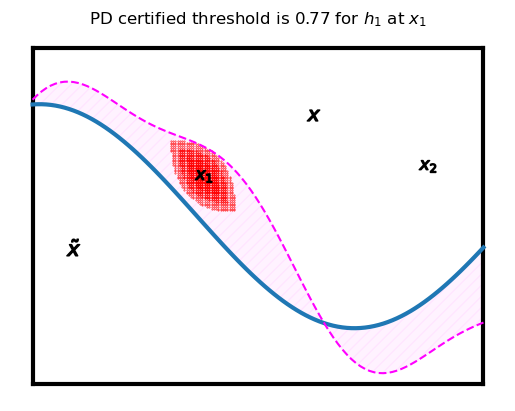

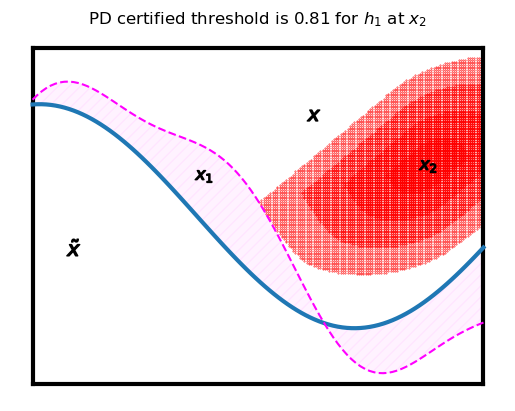

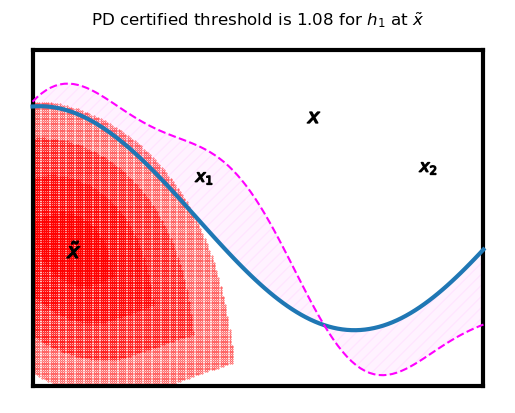

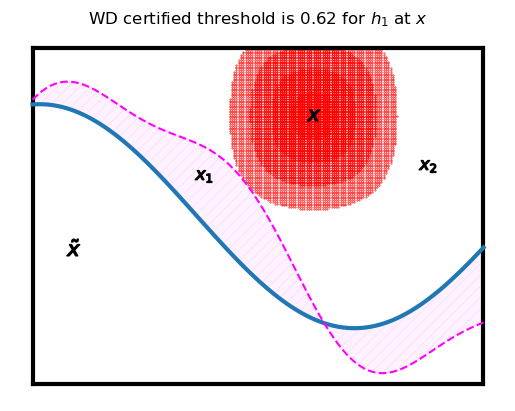

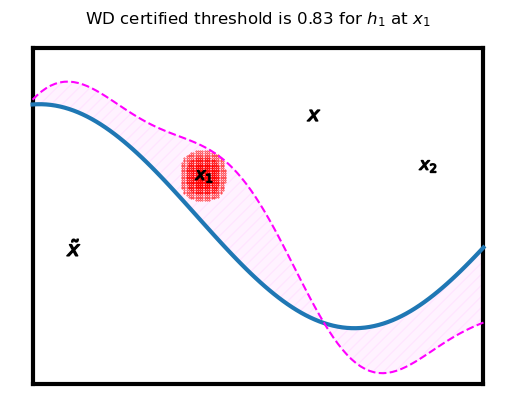

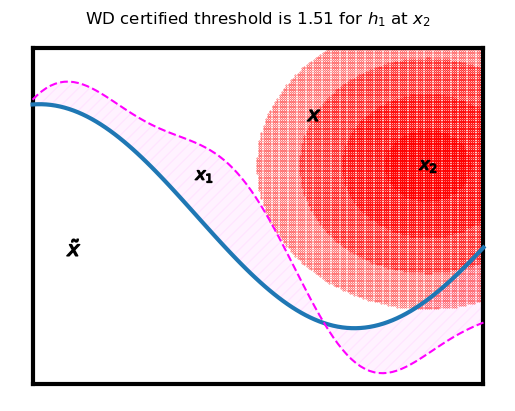

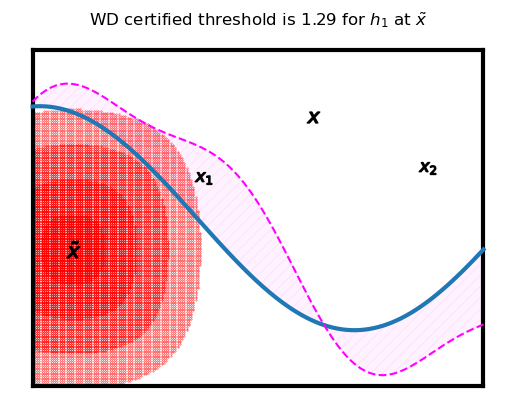

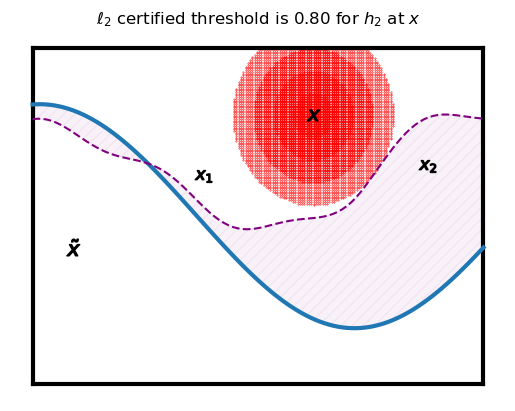

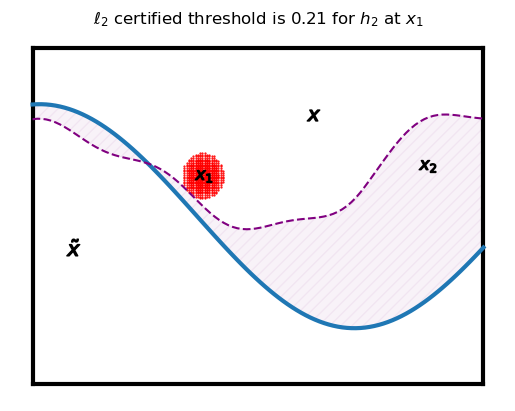

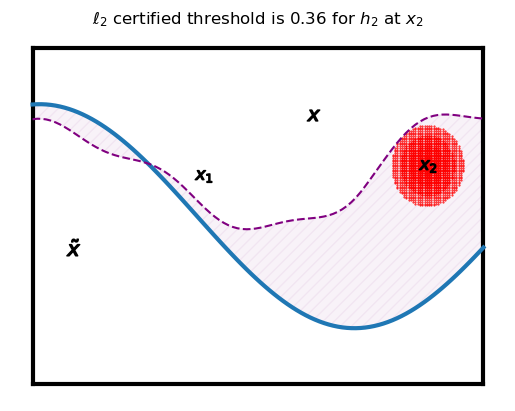

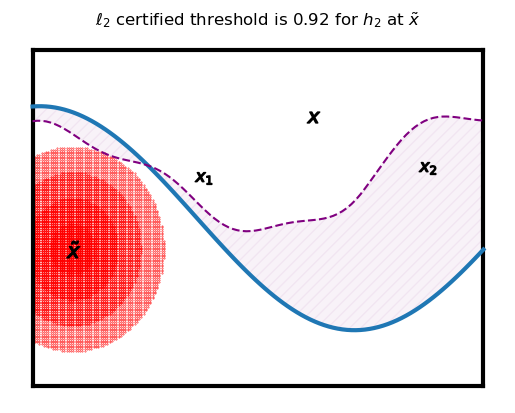

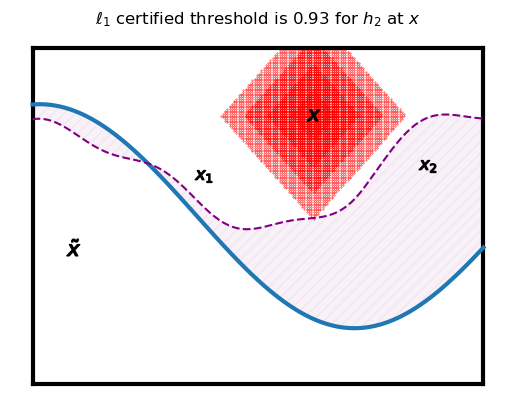

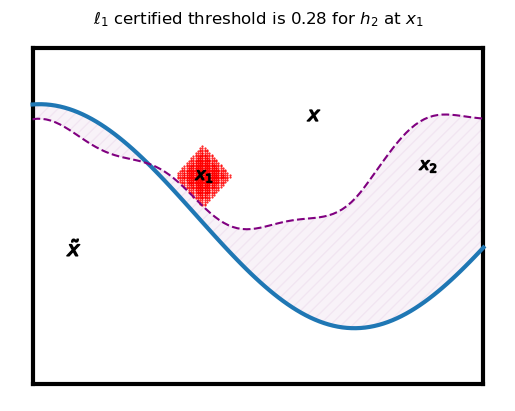

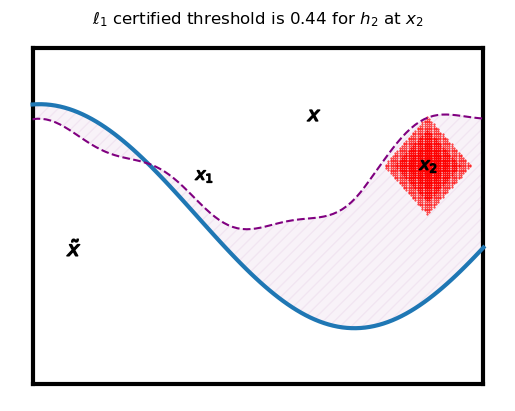

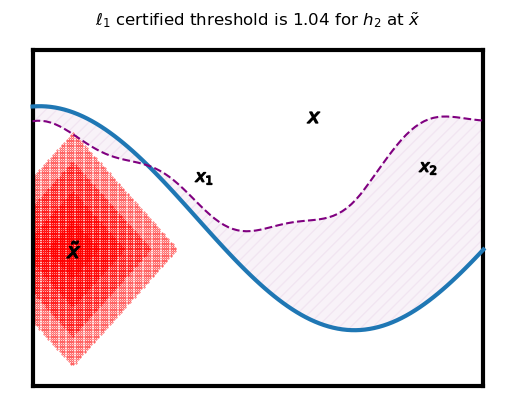

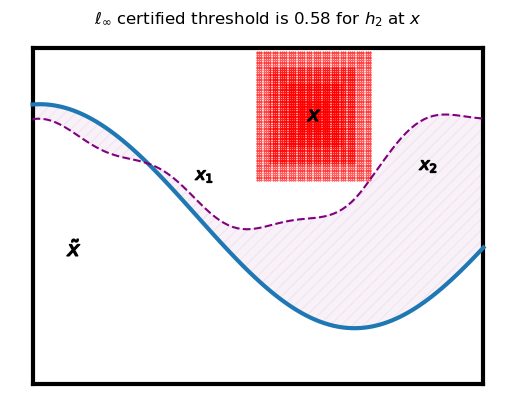

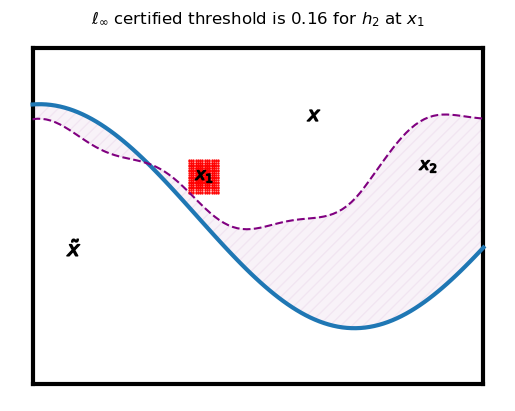

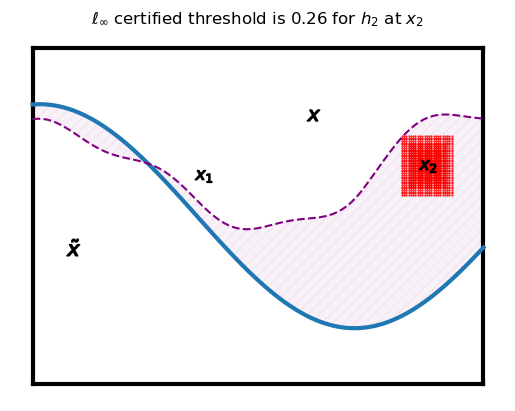

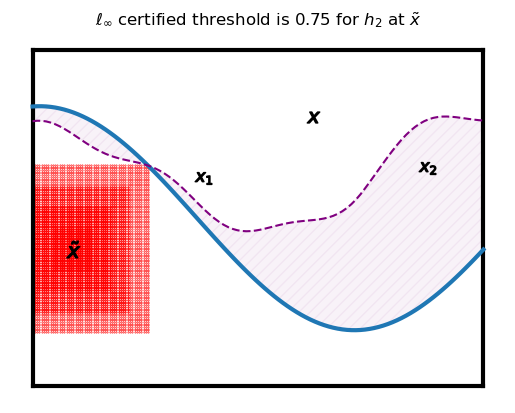

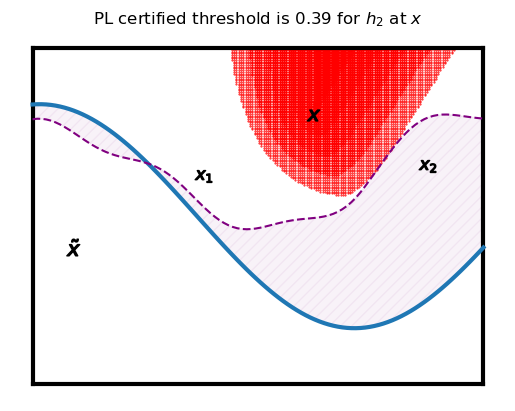

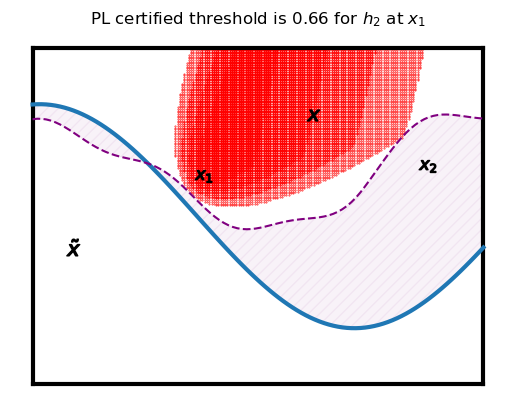

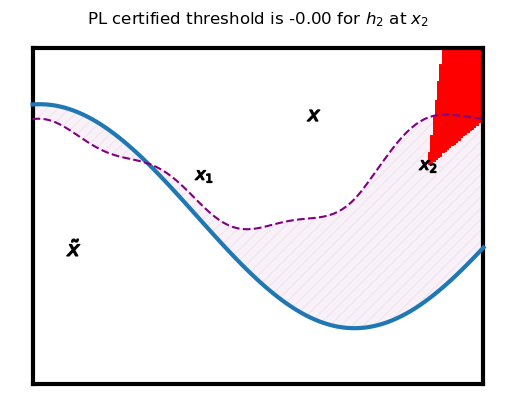

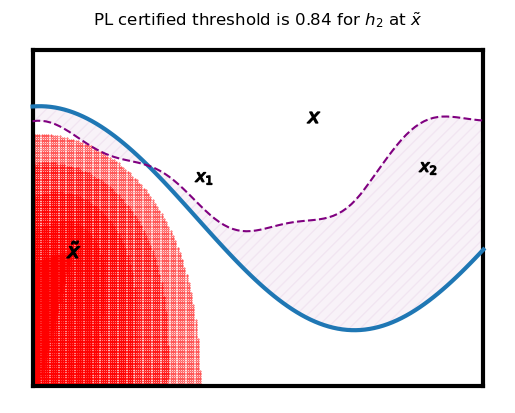

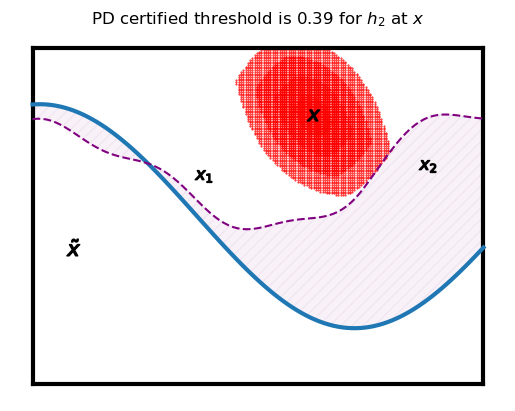

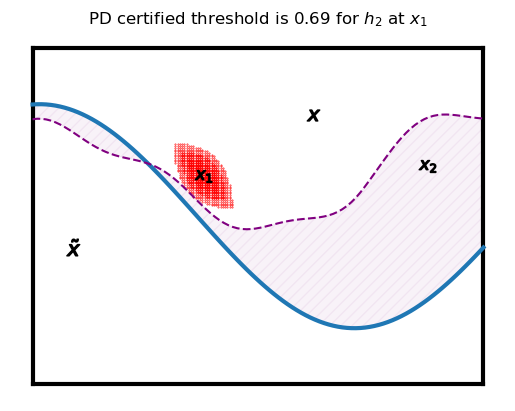

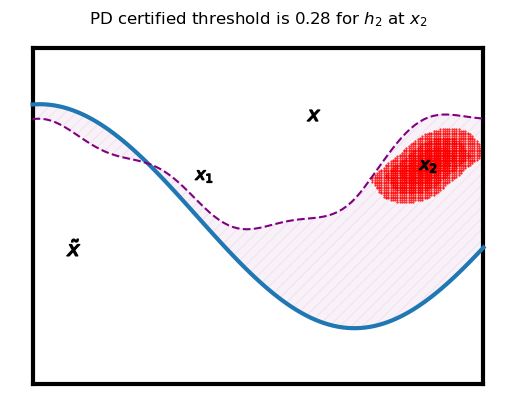

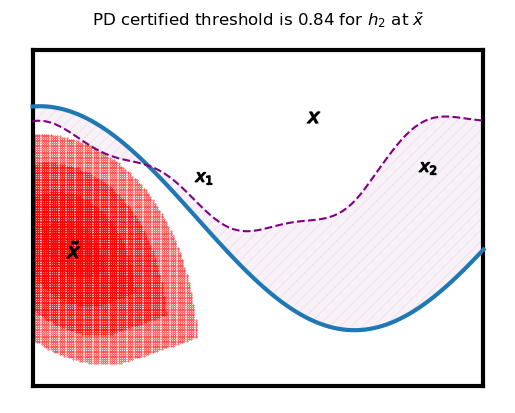

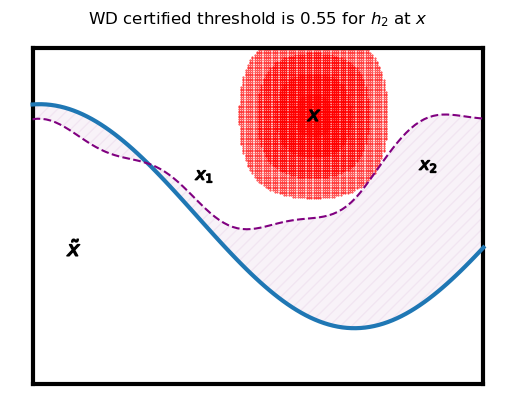

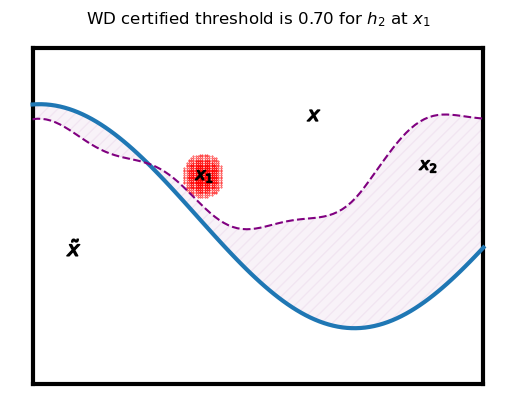

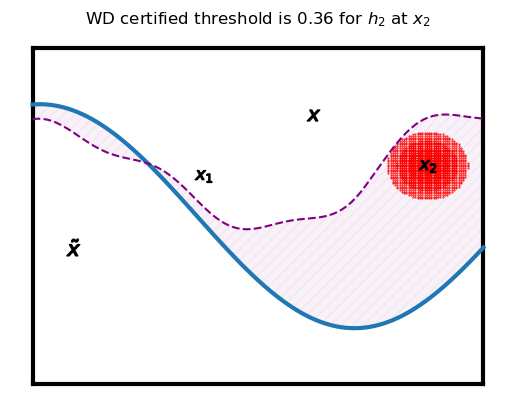

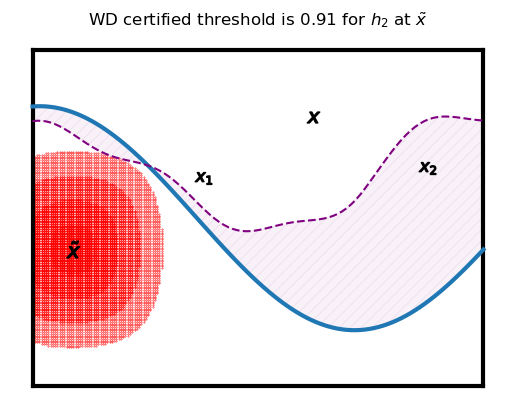

In [224]:
plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_hstar, h_index=None)

plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_h1, h_index=1)

plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_h2, h_index=2)
    

In [103]:
distance_domain_2 = get_distances(reference_domain[1], reference_labels[1], domain, true_labels, classifier=h_star, dist_type='l2')
print(len(distance_domain_2))
print(np.max(distance_domain_2))
print(np.min(distance_domain_2))

Computing distances at index: 39900, out of 39999 points.
40000
3.3620412
0.007838191


In [104]:
distance_domain_1 = get_distances(reference_domain[1], reference_labels[1], domain, true_labels, classifier=h_star, dist_type='l1')
print(len(distance_domain_1))
print(np.max(distance_domain_1))
print(np.min(distance_domain_1))

Computing distances at index: 39900, out of 39999 points.


40000
4.6610003
0.010748893


In [105]:
distance_domain_inf = get_distances(reference_domain[1], reference_labels[1], domain, true_labels, classifier=h_star, dist_type='linf')
print(len(distance_domain_inf))
print(np.max(distance_domain_inf))
print(np.min(distance_domain_inf))

Computing distances at index: 39900, out of 39999 points.
40000
2.8
0.006728679


In [149]:
distance_domain_PL = get_distances(reference_domain[1], reference_labels[1], domain, true_labels, classifier=h_star, dist_type='PL')
print(len(distance_domain_PL))
print(np.max(distance_domain_PL))
print(np.min(distance_domain_PL))


Computing distances at index: 39900, out of 39999 points.
40000
8.484757
0.0032607291


In [152]:
distance_domain_PD = get_distances(reference_domain[1], reference_labels[1], domain, true_labels, classifier=h_star, dist_type='PD')
print(len(distance_domain_PD))
print(np.max(distance_domain_PD))
print(np.min(distance_domain_PD))


Computing distances at index: 39900, out of 39999 points.
40000
9.764432
0.0207779


In [153]:
distance_domain_WD = get_distances(reference_domain[1], reference_labels[1], domain, true_labels, classifier=h_star, dist_type='WD')
print(len(distance_domain_WD))
print(np.max(distance_domain_WD))
print(np.min(distance_domain_WD))


Computing distances at index: 39900, out of 39999 points.
40000
11.478719
0.026964035


# Plot and save visualizations

In [ ]:
domain_np = domain.cpu().numpy()
domain_x = [d[0] for d in domain_np]
domain_y = [d[1] for d in domain_np]
print(len(domain_x))
print(len(domain_y))

In [100]:
x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
x, y_star, y_1, y_2 = generate_decision_boundary(corners)

(0.775, 5.725, -1.65, 1.65)

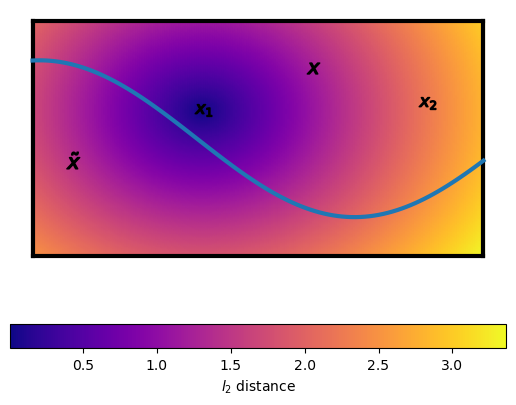

In [154]:
# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)
    
# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    
# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

plt.scatter(domain_x, domain_y, c=distance_domain_2, s=2, cmap="plasma") # s is a size of marker 
plt.colorbar(orientation='horizontal',label= r'$l_2$' + ' distance')


plt.axis('off')

(0.775, 5.725, -1.65, 1.65)

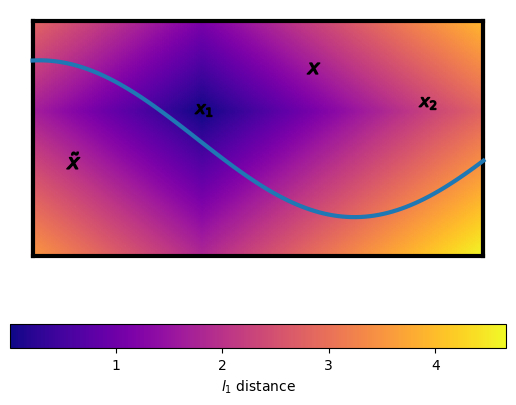

In [155]:
# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)
    
# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    
# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

plt.scatter(domain_x, domain_y, c=distance_domain_1, s=2, cmap="plasma") # s is a size of marker 
plt.colorbar(orientation='horizontal',label= r'$l_1$' + ' distance')


plt.axis('off')

(0.775, 5.725, -1.65, 1.65)

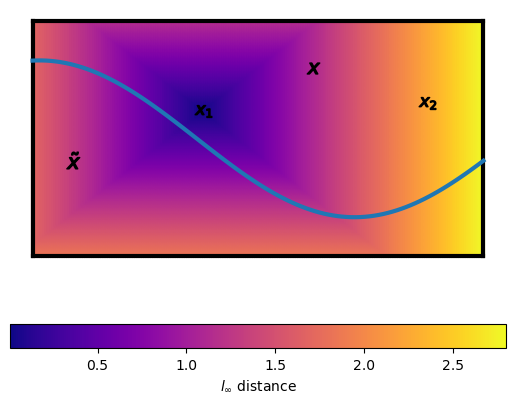

In [156]:
# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)
    
# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    
# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

plt.scatter(domain_x, domain_y, c=distance_domain_inf, s=2, cmap="plasma") # s is a size of marker 
plt.colorbar(orientation='horizontal',label= r'$l_{\infty}$' + ' distance')


plt.axis('off')

(0.775, 5.725, -1.65, 1.65)

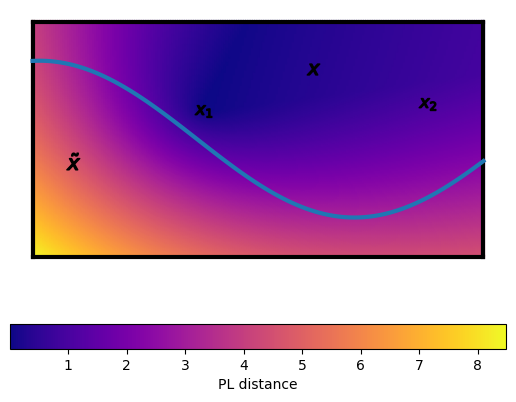

In [157]:
x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
x, y_star, y_1, y_2 = generate_decision_boundary(corners)

# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)
    
# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    
# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

# plot the PL distancs 
plt.scatter(domain_x, domain_y, c=distance_domain_PL, s=2, cmap="plasma") # s is a size of marker 
plt.colorbar(orientation='horizontal',label= 'PL distance')


plt.axis("off")

(0.775, 5.725, -1.65, 1.65)

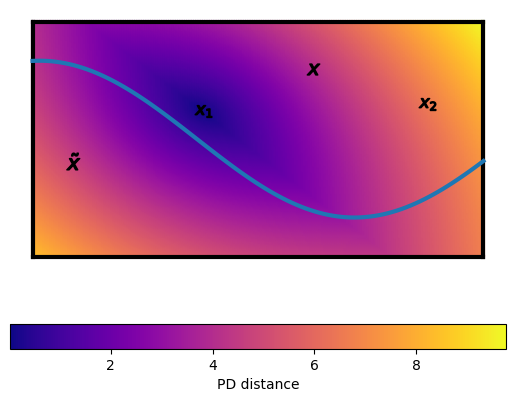

In [158]:
# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)
    
# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    
# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

# plot the PL distancs 
plt.scatter(domain_x, domain_y, c=distance_domain_PD, s=2, cmap="plasma") # s is a size of marker 
plt.colorbar(orientation='horizontal',label= 'PD distance')


plt.axis("off")

(0.775, 5.725, -1.65, 1.65)

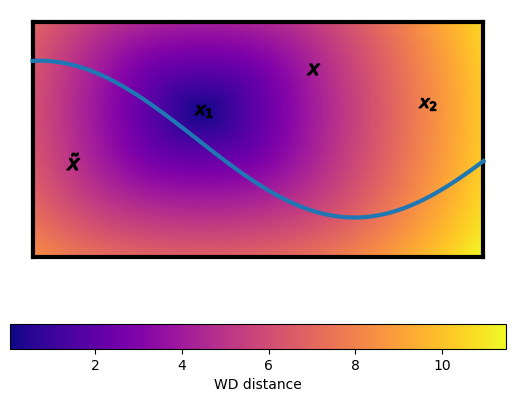

In [159]:
# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)
    
# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    
# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

# plot the PL distancs 
plt.scatter(domain_x, domain_y, c=distance_domain_WD, s=2, cmap="plasma") # s is a size of marker 
plt.colorbar(orientation='horizontal',label= 'WD distance')


plt.axis("off")

Text(0.5, 1.0, '$\\ell_2$sublevel set for threat levels in (0.0,1.0)')

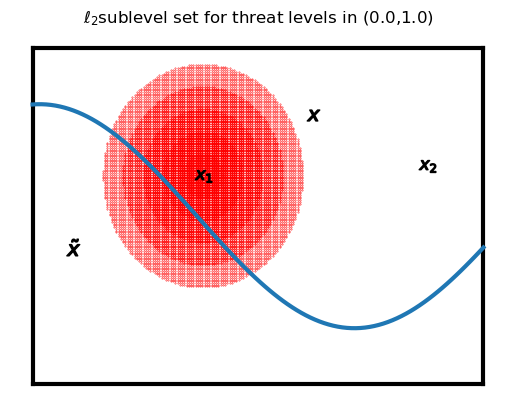

In [163]:
# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)    
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)

# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)

# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

epsilons = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
for eps in epsilons: 
    sublevel = sublevel_set(domain, distance_domain_2, eps)
    sublevel_x = [d[0] for d in sublevel]
    sublevel_y = [d[1] for d in sublevel]
    plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

plt.axis('off')
plt.title(r'$\ell_2$' + "sublevel set for threat levels in (" + str(epsilons[0]) + "," + str(epsilons[-1]) + ")")

Text(0.5, 1.0, '$\\ell_1$sublevel set for threat levels in (0.0,1.0)')

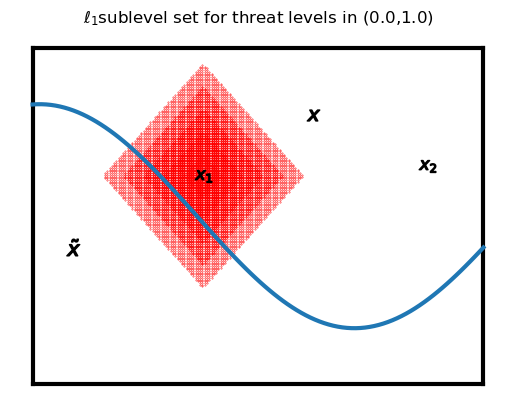

In [164]:
epsilons = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)    
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)

# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)

# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

for eps in epsilons: 
    sublevel = sublevel_set(domain, distance_domain_1, eps)
    sublevel_x = [d[0] for d in sublevel]
    sublevel_y = [d[1] for d in sublevel]
    plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

plt.axis('off')
plt.title(r'$\ell_1$' + "sublevel set for threat levels in (" + str(epsilons[0]) + "," + str(epsilons[-1]) + ")")

Text(0.5, 1.0, '$\\ell_{\\infty}$sublevel set for threat levels in (0.0,1.0)')

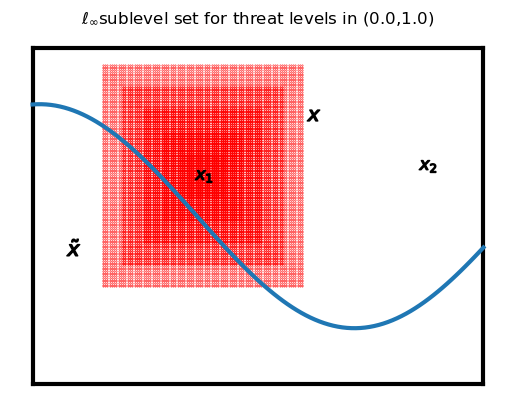

In [165]:
epsilons = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)    
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)

# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)

# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

for eps in epsilons: 
    sublevel = sublevel_set(domain, distance_domain_inf, eps)
    sublevel_x = [d[0] for d in sublevel]
    sublevel_y = [d[1] for d in sublevel]
    plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

plt.axis('off')
plt.title(r'$\ell_{\infty}$' + "sublevel set for threat levels in (" + str(epsilons[0]) + "," + str(epsilons[-1]) + ")")

Text(0.5, 1.0, 'PL sublevel set for threat levels in (0.0,1.0)')

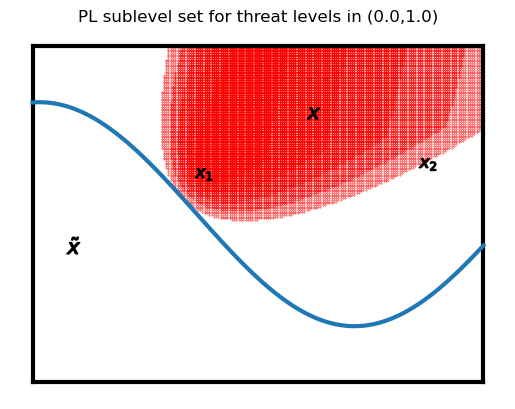

In [160]:
epsilons = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)    
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)

# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)

# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

for eps in epsilons: 
    sublevel_PL = sublevel_set(domain, distance_domain_PL, eps)
    sublevel_PL_x = [d[0] for d in sublevel_PL]
    sublevel_PL_y = [d[1] for d in sublevel_PL]
    plt.scatter(sublevel_PL_x, sublevel_PL_y, c='red', s=0.1/(0.1+eps))

plt.axis('off')
plt.title("PL sublevel set for threat levels in (" + str(epsilons[0]) + "," + str(epsilons[-1]) + ")")

Text(0.5, 1.0, 'PD sublevel set for threat levels in (0.0,1.0)')

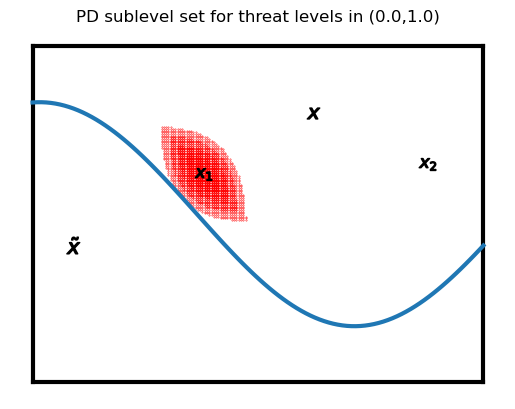

In [161]:
epsilons = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)    
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)

# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)

# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

for eps in epsilons: 
    sublevel = sublevel_set(domain, distance_domain_PD, eps)
    sublevel_x = [d[0] for d in sublevel]
    sublevel_y = [d[1] for d in sublevel]
    plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

plt.axis('off')
plt.title("PD sublevel set for threat levels in (" + str(epsilons[0]) + "," + str(epsilons[-1]) + ")")

Text(0.5, 1.0, 'WD sublevel set for threat levels in (0.0,1.0)')

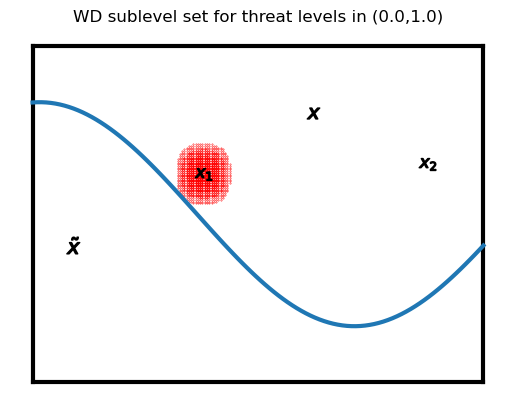

In [162]:
epsilons = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# plot the data domain
plt.plot(x_left, y_left, color="black", linewidth=3)    
plt.plot(x_right, y_right, color="black", linewidth=3)
plt.plot(x_down, y_down, color="black", linewidth=3)
plt.plot(x_up, y_up, color="black", linewidth=3)

# plot true labeling decision boundary 
plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)

# plot reference points
plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)

for eps in epsilons: 
    sublevel = sublevel_set(domain, distance_domain_WD, eps)
    sublevel_x = [d[0] for d in sublevel]
    sublevel_y = [d[1] for d in sublevel]
    plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

plt.axis('off')
plt.title("WD sublevel set for threat levels in (" + str(epsilons[0]) + "," + str(epsilons[-1]) + ")")

In [ ]:
# unsafe_dir, unsafe_normalization = compute_unsafe_dir(p_ref, domain)
# unsafe_pert = []
# for d in unsafe_dir:
#     unsafe_pert.append(sum(p_ref, d))

# unsafe_pert_x = [d.x for d in unsafe_pert]
# unsafe_pert_y = [d.y for d in unsafe_pert]


# sublevel_PL = sublevel_set(domain, distance_domain_PL, 0.0)

# sublevel_PL_x = [d.x for d in sublevel_PL]
# sublevel_PL_y = [d.y for d in sublevel_PL]


# plt.scatter(sublevel_PL_x, sublevel_PL_y, c='green', s=0.1)
# plt.scatter(unsafe_pert_x, unsafe_pert_y, c='red', s=0.1)
# #plt.plot([3.8],[0.9], color='black', marker=r'$x$', markersize=9)
# #plt.plot([2.7],[0.361], color='red', marker=r'$x_1$', markersize=12)
# #plt.plot([1.4],[-0.276], color='red', marker=r'$\tilde{x}$', markersize=12)
# plt.plot([4.94],[0.452], color='red', marker=r'$x_2$', markersize=12)
# plt.plot(x, y, color="black", label="h*", linewidth=3)
# plt.plot(x1,y1, color="black", linewidth=3)
# plt.plot(x2,y2, color="black", linewidth=3)
# plt.plot(x3,y3, color="black", linewidth=3)
# plt.plot(x4,y4, color="black", linewidth=3)
# plt.axis('off')
# plt.title("x + Unsafe Directions")

# Things to do

## CodeBase 
- 

## Code Refactor 
- Convert point class to torch vector and have functionality that tensors converts to numpy arrays (and check devices) for plotting 
- Modularize existing code to print all relevant plots and save relevant figures (sublevel sets at p0,p1,p2, p-til)
- Save the data domain as a data set. with a tag of "exact partition"
- Add data-generator code that fixes and samples from grid when asked for "synthetic2D"
- Add data-generator code that does regular data-loading for "MNIST, BlockMNIST, CIFAR-x, Imagenet"
- Add dataset-hyperparams for each. 

## Threat functions 
- Implement isotropic functions
- For each point, compute unsafe directions and exact normalization. 
- Implement non-isotropic threat functions. 

## Synthetic2D
- Choose synthetic h, h1, h2 and data domain. 
- Visualize data domain with points p0, p1, p2 and ptil. 
- Design class-wise marginal input distribution that are tightly concentrated. Sample 500 points for each label. 
- Find certified radius for each triple (h, x, d) w.r.t each d in distance metrics (N, approx-n, k-approx-N), each x in the data domain, and h in {h*, h1,h2} by searching over sublevel sets. 
- Visualize as intensity maps. Show variation between h1 and h2. 

## Observed and k-Observed
- Compute unsafe directions with beta normalization w.r.t all sample points. Add resulting distances as observed-PL. 
- Given any data-set find k-subsets for each class using greedy approximation of cosine similarity. Add resulting distances as k-observed-PL. 
- Choose beta for normalization based on the minimal norm of all observed unsafe directions that are within a kappa threshold in cosine similarity. 
- Run through visualization and certification sequence for PL (if exact), observed-PL and k-observed-PL. 

## Projection
- Given a reference point pref, a new point p, Find projection of p to sublevel set Td(pref, epsilon). 
- Use greedy projection algorithm for each non-isotropic distance. Run T rounds and then scale the iterate if it is still not in the sublevel set. 

## Augment
- N-Mixup 
- N-Project
- Visualize points added according to both on the "synthetic2D" dataset. 

## Attack and Train
- N-PGD : Generic PGD + projection onto C set where C is specific by a N-threat function or just a simple threat function. 
- Adversarial training with N-PGD. 
- Robust Accuracy evaluation. 
- Learn tiny neural network on synthetic2D. show N-PGD attack points. 

## SOTA Evaluation
- Import model weights from RobustBench and plug into existing code-base. 
- Compute robust accuracy under PGD and N-PGD attacks. Show ranking and robust accuracy curves. 
- Finetune top-5 models with N-Mixup, N-Project and N-adversarial training, show robust accuracy on all combinations and hyperparameter sweeps. 


## Certified Robustness  
- Search over approximation of predictor intensity based on LirPA, plot histograms and certified accuracy curves. 
